In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt


## Friday Week 0 (05/07/2024): Have to create a class for an ejected mass profile
 - Look at https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/profiles/nfw.py as an example of the creation of a halo mass profile.
 - Python docs on classes: https://docs.python.org/3/tutorial/classes.html
 - Selected bits: 
   - the class inheritance mechanism allows multiple base classes
   - a derived class can override any methods of its base class or classes
   - a method can call the method of a base class with the same name

$\rho_X(r)\ = Ma ^{-3} f_X g_X(r)\$. 

- M = total halo mass
- $f_X$ = the fraction of that mass in gas species X
- $g(x)$ = the profile, which satisfies the normalisation $4\pi \int^{\inf)_0 dr r^2 g_X(r)\ = 1$
- a = the scale factor

$f_c + f_b + f_e + f_* = 1$ AND (assuming adiabaticity) $f_b + f_e + f_* = \bar{f}_b \equiv \frac{\Omega_b}{\Omega_M}$

ejected gas fraction: $f_e(M)\ = \bar{f}_b - f_b(M)\ -f_*(M)\ $    
(with eqns given for these 3) (see: [pdf](../Background-reading/XrayCrossCorrelations-1.pdf)).  
$g_e(r)\ = \frac{exp \left ( \frac{-r^2}{2r^2_e} \right) }{(2 \pi r^2_e)^{3/2}} $   
with characteristic scale $r_e$.
Then Fourier transform of the profile is (analytical):   
$\tilde{g}_e(k)\ = exp \left( \frac{-(kr_e)^2}{2} \right)$

----------------------------------------------------------------------------
In (paper)[file:///Users/lambe/Documents/GitHub/Oxford-Intern-2024/Background-reading/XrayCrossCorrelations-1.pdf], see that:   
$\rho_x(r)\ = M f_x\ a^{-3} g_x(r)\ $    
$g_{ej}(r)\ = \frac{1}{(2\pi r_{ej}^2)^{3/2}} * exp[- \frac{1}{2} \left( \frac{r}{r_{ej}} \right)^2 ]$   
$\to \rho_{ej}(r)\ = M f_{ej}\ \frac{1}{a^{3}(2\pi r_{ej}^2)^{3/2}} * exp[- \frac{1}{2} \left( \frac{r}{r_{ej}} \right)^2 ]$    
                  $= M f_{ej}\ \frac{1}{(a\ r_{ej}\ \sqrt{2\pi} )^{3}} * exp[- \frac{1}{2} \left( \frac{r}{r_{ej}} \right)^2 ]$

And the Fourier profile is:   
$\rho_{ej}(k)\ = M f_{ej}\ a^{-3} \tilde{g}_{ej}(k)\ = M f_{ej}\ a^{-3} exp[-(kr_{ej})^2/2] $   
as $\tilde{g}_{ej}(k)\ = exp[-(kr_{ej})^2/2] \to 1$ as $k \to 1 $   

### Now Working on:
$r_e = 0.75\eta_br_{esc} \simeq 0.75\eta_b* 0.5\sqrt{\Delta} r_{vir}$    
with "$\Delta = 200$ in our case".   

In [133]:
class ejGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the ejected gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, r_ej):
        self.r_ej = r_ej  # may need to add an rEj parameter into real & Fourier profiles below
        super(ejGas_profile, self).__init__(mass_def=mass_def)

    def _real(self, r, M, r_ej, 
              scale_a=1, delta=200, eta_b = -0.3, f=1): # set the default pars for scale factor a & fraction of total mass f
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        rEj_use = np.atleast_1d(r_ej)
        r_vir = self.mass_def.get_radius(cosmo, M_use, scale_a) / scale_a # halo virial radius
        r_e = 0.375*r_vir*np.sqrt(delta)*eta_b # eta_b = ? (looks like n_b) (recheck default value)
        print(r_vir)
        print(r_e)

# Returns: float or array_like: halo profile. Shape of output `(N_M, N_r)` where `N_r` & `N_m` = the sizes of `r` & `M` respectively.
        prefix = M_use * f * (1/(scale_a*np.sqrt(2*np.pi)*r_e))**3
        x = r_use[None, :] / r_e[:, None]
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    def _fourier(self, k, M, r_ej, 
                 scale_a=1, f=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        rEj_use = np.atleast_1d(r_ej)

        prefix = M_use * f / a**3
        x = k_use[None, :] * rEj_use[:, None]
        # delete: prof = np.exp(-(1/2)*(r_use[None, :]/r_ej[:, None])**2)
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

In [135]:
# working with z = 0 (today) ; therefore a = 1
# use a mass definition with Delta = 200
hmd_200c = ccl.halos.MassDef200c
rejT = 100
cosmo = ccl.Cosmology(Omega_c = 0.25, Omega_b=0.05, h=0.07, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
trial_ejProf = ejGas_profile(hmd_200c, rejT)

In [137]:
trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
profTrial_real = trial_ejProf._real(trial_r, trial_M, rejT)
profTrial_real

[1.63723745 2.59895246 4.44414619]
[-2.60482884 -4.13490804 -7.07059329]


array([[-1.79621959e+10, -1.79621958e+10, -1.79621957e+10, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.79622757e+10, -1.79622757e+10, -1.79622756e+10, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-1.79623103e+10, -1.79623102e+10, -1.79623102e+10, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

/var/folders/fj/p1qj16jj5pl9df1rgw6p12tc000vry/T/ipykernel_5464/2412501923.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log');


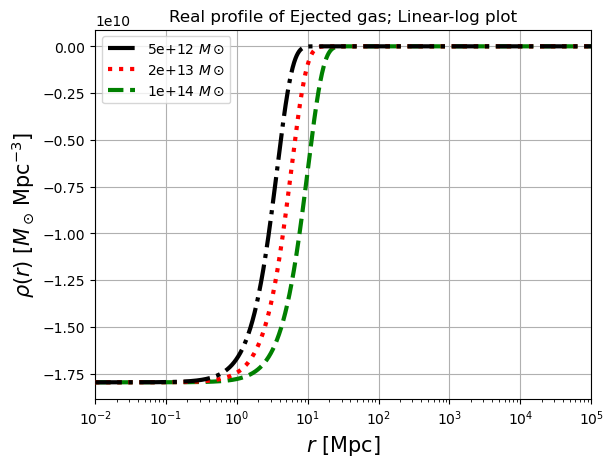

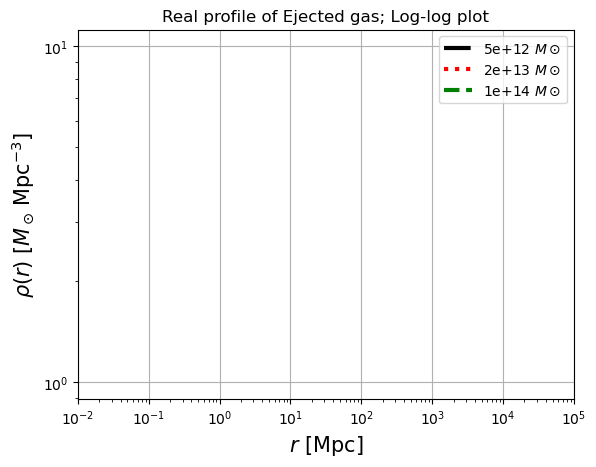

In [139]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Ejected gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
plt.legend(loc='best')
plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Ejected gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

# Cell below is with $r_{ej} \equiv 100\ Mpc$

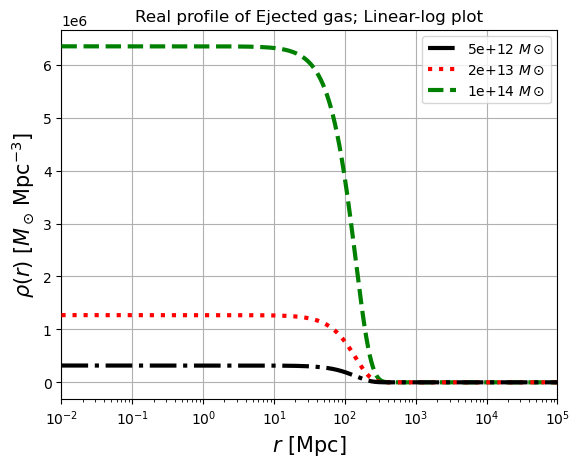

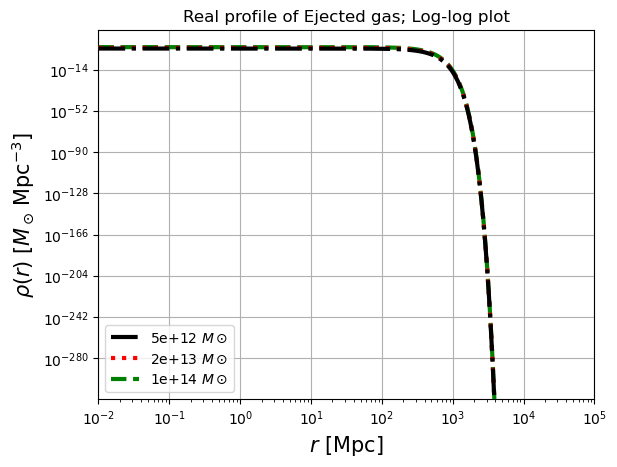

In [100]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Ejected gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
plt.legend(loc='best')
plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Ejected gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

In [15]:
trial_k = np.geomspace(1E-20,1E2,100000)
trial_M = np.array([5E12,2E13, 1E14])
profTrial_fourier = trial_ejProf._fourier(trial_k, trial_M, rejT)
profTrial_fourier

array([[5.e+12, 5.e+12, 5.e+12, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e+13, 2.e+13, 2.e+13, ..., 0.e+00, 0.e+00, 0.e+00],
       [1.e+14, 1.e+14, 1.e+14, ..., 0.e+00, 0.e+00, 0.e+00]])

#### Normalisation of profiles means that:   
$\rho(k \to 0)\ _x = \frac{M_x}{a^3} [f_x]$   
#### So plotting $y = x + \frac{M_x}{a^3} [f_x]$ should give an overlap with the [normalised] Fourier density profile's plateau

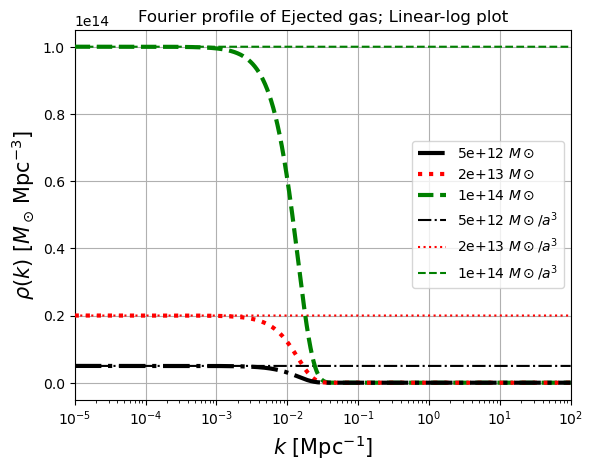

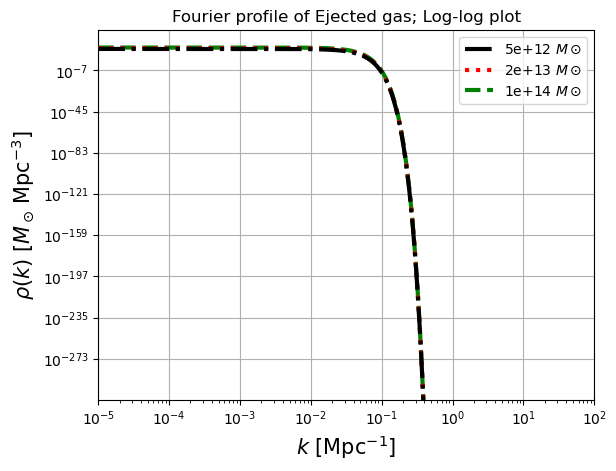

In [29]:
#### colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
for mass, col in zip(trial_M, colours):
    plt.plot(trial_k, 1*trial_k + mass, col, zorder=(10-i), label=f'{mass:.1g} $M \\odot /a^3$')   # here, a=1 & f=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Ejected gas; Linear-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i], colours[i], lw=3, zorder = (10-i), label=f'{trial_M[i]:.1g} $M \\odot $')
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', fontsize=15);
plt.title('Fourier profile of Ejected gas; Log-log plot')
plt.grid(True)
plt.legend(loc='best')
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);